Load deepcell and utilities

In [1]:
import tifffile
import deepcell_toolbox.processing as processing
from deepcell.applications import CytoplasmSegmentation, NuclearSegmentation, Mesmer
import matplotlib.pyplot as plt
import numpy as np

## Data

DeepCell does not provide any tools for opening images on its own. Instead, this environment (when loaded from the provided YAML) includes packages for handling image loading including pillow, opencv, and tifffile. For the purpose of this example, we have opted to use tifffile.

In [8]:
collagen_image = tifffile.imread('MAX_registered time points-1.tif')
collagen_image.shape

(98, 2, 368, 341)

DeepCell expects images to come in the shape [B,X,Y,C] where B = batch. This image comes in the shape [T,C,X,Y] which means a simple permute can allow us to use DeepCell's pretrained models.

In [9]:
collagen_image = np.transpose(collagen_image, (0,2,3,1))
collagen_image.shape

(98, 368, 341, 2)

Rather than treating this image as batches - which is what would happen if we don't index into `collagen_image` - we will look at just one time stamp and treat it as one batched image. To make sure we still keep the 4 dimensions as specified earlier, we use numpy to expand an empty dimension in the first axis.

In [11]:
collagen_image_at_time = collagen_image[16]
collagen_image_at_time = np.expand_dims(collagen_image_at_time, 0)
collagen_image_at_time.shape

(1, 368, 341, 2)

## Example Image

Now that we have formatted the image correctly, we can take a look at the channels to analyze

Text(0.5, 1.0, 'Cells')

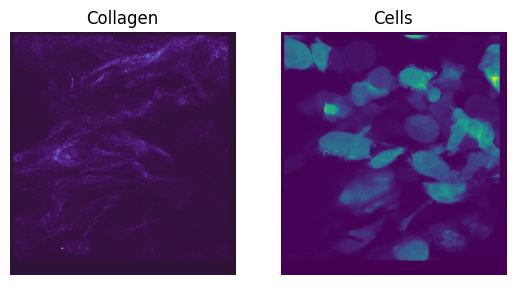

In [12]:
plt.subplot(1,2,1)
plt.imshow(collagen_image_at_time[0,:,:,0], cmap='twilight_shifted')
plt.axis('off')
plt.title(f'Collagen')

plt.subplot(1,2,2)
plt.imshow(collagen_image_at_time[0,:,:,1])
plt.axis('off')
plt.title(f'Cells')